In [2]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import os
import math
#import imageio
from scipy.ndimage.interpolation import map_coordinates
from pprint import pprint
import glob
from scipy import interpolate
from scipy.interpolate import RegularGridInterpolator
from copy import copy
from copy import deepcopy
#from mpl_toolkits.axes_grid1 import make
#_axes_locatable
%matplotlib inline
from scipy import stats
import multiprocessing as mp
import matplotlib.patches as patches

In [3]:
_wbgyr_cdict = {'red': ((0.0,  255./255, 255./255),
                        (0.125, 173./255, 173./255),
                        (0.25,  95./255,  95./255),
                        (0.375, 73./255,  73./255),
                        (0.5,  165./255, 164./255),
                        (0.625, 248./255, 248./255),
                        (0.75, 236./255, 236./255),
                        (0.875, 200./255, 200./255),
                        (1.0,  146./255, 146./255)),
                'green': ((0.0,  255./255, 255./255),
                          (0.125, 224./255, 224./255),
                          (0.25, 163./255, 163./255),
                          (0.375, 166./255, 166./255),
                          (0.5,  207./255, 207./255),
                          (0.625, 184./255, 184./255),
                          (0.75,  86./255,  86./255),
                          (0.875, 29./255,  29./255),
                          (1.0,   21./255,  21./255)),
                'blue': ((0.0,  255./255, 255./255),
                         (0.125, 248./255, 248./255),
                         (0.25, 214./255, 214./255),
                         (0.375, 120./255, 120./255),
                         (0.5,   81./255,  81./255),
                         (0.625, 73./255,  73./255),
                         (0.75,  41./255,  41./255),
                         (0.875, 38./255,  38./255),
                         (1.0,   25./255,  25./255))}
# And reverse
_wbgyr_cdict_r = deepcopy(_wbgyr_cdict)
for i in _wbgyr_cdict_r.keys():
    _wbgyr_cdict_r[i] = [(1-j[0], j[1], j[2]) for j in _wbgyr_cdict_r[i]]
    _wbgyr_cdict_r[i].reverse()

cmap = LinearSegmentedColormap('WBGYR', _wbgyr_cdict)
cmap.set_bad('#D2D2D2')
plt.register_cmap(cmap=cmap)

cmap_r = LinearSegmentedColormap('WBGYR', _wbgyr_cdict_r)
cmap_r.set_bad('#D2D2D2')
plt.register_cmap(cmap=cmap_r)

In [7]:
landocean[offset*3::3]

<xarray.DataArray 'ConvOrigin' (time: 2856, lat: 60, lon: 360)>
dask.array<getitem, shape=(2856, 60, 360), dtype=float32, chunksize=(8, 60, 360), chunktype=numpy.ndarray>
Dimensions without coordinates: time, lat, lon

In [17]:
import warnings
print('is it doing?')
timelen=499
yedges_net = np.arange(-650,650,1)
yedges_lw = np.arange(-500,0,1)
yedges_sw = np.arange(-100,900,1)
yedges_solar = np.arange(0,1400,5)
xedges = np.arange(0,timelen+1,1)

cereshour = 8760
k=0
year = 2008

tsc = xr.open_mfdataset('/disk1/Users/gah20/TSC/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['TSC'][:,2:62]
landocean = xr.open_mfdataset('/disk1/Users/gah20/TSC/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['ConvOrigin'][:,2:62]
aodtsc = xr.open_mfdataset('/disk1/Users/gah20/TSC/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['ConvAOD'][:,2:62]
detinsit = xr.open_mfdataset('/disk1/Users/gah20/TSC/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['ConvCir'][:,2:62]

isccp = xr.open_mfdataset('/net/seldon/disk2/Users/gah20/ISCCP/access/isccp-basic/hgg/'+str(year)+'*/200*.nc',combine='nested',concat_dim='time')
taupc = isccp['n_pctaudist']
levtau = isccp['levtau']
levpc = isccp['levpc']
tauraw = isccp['tau']
pcraw = isccp['pc']
isccptime = isccp['time']

ds_w = xr.open_mfdataset('/net/seldon/disk1/Data/CERES/SYN1deg-Hour-Ed4/'+str(year)+'/CERES_SYN1deg-1H_Terra-Aqua-MODIS_Ed4.1_Total_*.nc',combine = 'by_coords', concat_dim="time")
swall = ds_w['toa_sw_all_1h'][:]
swclr = ds_w['toa_sw_clr_1h'][:]
lwall = ds_w['toa_lw_all_1h'][:]
lwclr = ds_w['toa_lw_clr_1h'][:]
netall = ds_w['toa_net_all_1h'][:]
netclr = ds_w['toa_net_clr_1h'][:]
solar = ds_w['toa_solar_all_1h'][:]
timeceres = ds_w['time'][:]
cf = ds_w['cldarea_total_1h'][:]

offset = np.argmin(np.abs(isccp['time'][:].values - ds_w['time'][0].values))

meanlw = np.nanmean(lwclr[:],axis=0)
levels = 3
lowcldamt = 1
lowcloudraw = np.nansum(np.nansum(isccp['n_pctaudist'][offset:,:,levels:,60:120],axis=1),axis=1)
lowcloud_day = np.where(lowcloudraw<0,np.nan,lowcloudraw)
lowcloud_night = np.where(np.nansum(isccp['n_pcdist'][offset:,levels:,60:120],axis=1)>100,np.nan,np.nansum(isccp['n_pcdist'][offset:,levels:,60:120],axis=1))
lowcloud = np.where(np.isnan(lowcloud_day),lowcloud_night,lowcloud_day)


timeceres[0::3][0:len(isccp['time'][offset:])]


swcldy  = (swall[0::3][0:len(isccp['time'][offset:])] - swclr[0::3][0:len(isccp['time'][offset:])])
netcldy = (netall[0::3][0:len(isccp['time'][offset:])] - netclr[0::3][0:len(isccp['time'][offset:])])

lwclr_f = np.where(np.isnan(lwclr[0::3][0:len(isccp['time'][offset:])]),meanlw,lwclr[0::3][0:len(isccp['time'][offset:])])
lwcldy = (lwall[0::3][0:len(isccp['time'][offset:])] - lwclr_f) 

solar_t = solar[0::3][0:len(isccp['time'][offset:])]
swcldy_dayf = np.where((lowcloud_day<lowcldamt),swcldy,np.nan)
lwcldy_dayf = np.where((lowcloud_day<lowcldamt),lwcldy,np.nan)

swcldy_f_nans = np.where((lowcloud<lowcldamt),swcldy,np.nan)
lwcldy_f = np.where((lowcloud<lowcldamt),lwcldy,np.nan)
lwcldy_f = np.where(lwcldy_f>0,np.nan,lwcldy_f)

tsc_t = (np.asarray(tsc[offset*3::3]))
tsc_d = np.asarray(np.where(detinsit[offset*3::3]>=0,tsc[offset*3::3],np.nan))
tsc_i = np.asarray(np.where(np.isnan(tsc_d),tsc[offset*3::3],np.nan))
tsc_o = np.asarray(np.where(landocean[offset*3::3]>0,np.nan,tsc[offset*3::3]))
tsc_l = np.asarray(np.where(landocean[offset*3::3]<0,np.nan,tsc[offset*3::3]))

tsc_d_o = np.where(np.isnan(tsc_o),np.nan,tsc_d)
tsc_d_l = np.where(np.isnan(tsc_l),np.nan,tsc_d)
tsc_i_o = np.where(np.isnan(tsc_o),np.nan,tsc_i)
tsc_i_l = np.where(np.isnan(tsc_l),np.nan,tsc_i)

swcldy_dayf = np.where(solar_t>0,swcldy_dayf,0)
swcldy_f = np.where(solar_t>0,swcldy_f_nans,0)
swcldy_fg = np.where(lowcloud<lowcldamt,swcldy_f,np.nan)
swcldy_fg = np.where(np.isnan(lwcldy_f),np.nan,swcldy_fg)


H_sw_all, xedges, yedges_sw = np.histogram2d(tsc_t.flatten(),np.asarray(swcldy_fg[0:len(tsc_d)]).flatten(), bins=(xedges,yedges_sw))
H_lw_all, xedges, yedges_lw = np.histogram2d(tsc_t.flatten(),np.asarray(lwcldy_f[0:len(tsc_d)]).flatten(), bins=(xedges,yedges_lw)) 

H_sw_det, xedges, yedges_sw = np.histogram2d(tsc_d.flatten(),np.asarray(swcldy_fg[0:len(tsc_d)]).flatten(), bins=(xedges,yedges_sw))
H_lw_det, xedges, yedges_lw = np.histogram2d(tsc_d.flatten(),np.asarray(lwcldy_f[0:len(tsc_d)]).flatten(), bins=(xedges,yedges_lw))

H_sw_ins, xedges, yedges_sw = np.histogram2d(tsc_i.flatten(),np.asarray(swcldy_fg[0:len(tsc_d)]).flatten(), bins=(xedges,yedges_sw))
H_lw_ins, xedges, yedges_lw = np.histogram2d(tsc_i.flatten(),np.asarray(lwcldy_f[0:len(tsc_d)]).flatten(), bins=(xedges,yedges_lw))

H_lw_l, xedges, yedges_lw = np.histogram2d(tsc_l.flatten(),np.asarray(lwcldy_f[0:len(tsc_d)]).flatten(), bins=(xedges,yedges_lw))
H_sw_l, xedges, yedges_sw = np.histogram2d(tsc_l.flatten(),np.asarray(swcldy_fg[0:len(tsc_d)]).flatten(), bins=(xedges,yedges_sw))
H_lw_o, xedges, yedges_lw = np.histogram2d(tsc_o.flatten(),np.asarray(lwcldy_f[0:len(tsc_d)]).flatten(), bins=(xedges,yedges_lw))
H_sw_o, xedges, yedges_sw = np.histogram2d(tsc_o.flatten(),np.asarray(swcldy_fg[0:len(tsc_d)]).flatten(), bins=(xedges,yedges_sw))

H_sw_det_o, xedges, yedges_sw = np.histogram2d(tsc_d_o.flatten(),np.asarray(swcldy_fg[0:len(tsc_d_o)]).flatten(), bins=(xedges,yedges_sw))
H_lw_det_o, xedges, yedges_lw = np.histogram2d(tsc_d_o.flatten(),np.asarray(lwcldy_f[0:len(tsc_d_o)]).flatten(), bins=(xedges,yedges_lw))
H_sw_det_l, xedges, yedges_sw = np.histogram2d(tsc_d_l.flatten(),np.asarray(swcldy_fg[0:len(tsc_d_l)]).flatten(), bins=(xedges,yedges_sw))
H_lw_det_l, xedges, yedges_lw = np.histogram2d(tsc_d_l.flatten(),np.asarray(lwcldy_f[0:len(tsc_d_l)]).flatten(), bins=(xedges,yedges_lw))

H_sw_ins_o, xedges, yedges_sw = np.histogram2d(tsc_i_o.flatten(),np.asarray(swcldy_fg[0:len(tsc_d_o)]).flatten(), bins=(xedges,yedges_sw))
H_lw_ins_o, xedges, yedges_lw = np.histogram2d(tsc_i_o.flatten(),np.asarray(lwcldy_f[0:len(tsc_d_o)]).flatten(), bins=(xedges,yedges_lw))
H_sw_ins_l, xedges, yedges_sw = np.histogram2d(tsc_i_l.flatten(),np.asarray(swcldy_fg[0:len(tsc_d_l)]).flatten(), bins=(xedges,yedges_sw))
H_lw_ins_l, xedges, yedges_lw = np.histogram2d(tsc_i_l.flatten(),np.asarray(lwcldy_f[0:len(tsc_d_l)]).flatten(), bins=(xedges,yedges_lw))

is it doing?


/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice


In [24]:
timelen=499

H_norm_lw_det_o = np.zeros((timelen,499))
H_norm_sw_det_o = np.zeros((timelen,999))
H_norm_lw_ins_o = np.zeros((timelen,499))
H_norm_sw_ins_o = np.zeros((timelen,999))

H_norm_lw_det_l = np.zeros((timelen,499))
H_norm_sw_det_l = np.zeros((timelen,999))
H_norm_lw_ins_l = np.zeros((timelen,499))
H_norm_sw_ins_l = np.zeros((timelen,999))


H_norm_lw_det = np.zeros((timelen,499))
H_norm_sw_det = np.zeros((timelen,999))
H_norm_lw_ins = np.zeros((timelen,499))
H_norm_sw_ins = np.zeros((timelen,999))

H_norm_lw_all = np.zeros((timelen,499))
H_norm_sw_all = np.zeros((timelen,999))

H_norm_lw_l = np.zeros((timelen,499))
H_norm_sw_l = np.zeros((timelen,999))
H_norm_lw_o = np.zeros((timelen,499))
H_norm_sw_o = np.zeros((timelen,999))


for i in range(timelen):

    H_norm_lw_det[i] = H_lw_det[i] / np.sum(H_lw_det[i])
    H_norm_sw_det[i] = H_sw_det[i] / np.sum(H_sw_det[i])

    H_norm_sw_ins[i] = H_sw_ins[i] / np.sum(H_sw_ins[i])
    H_norm_lw_ins[i] = H_lw_ins[i] / np.sum(H_lw_ins[i])

    H_norm_lw_all[i] = H_lw_all[i] / np.sum(H_lw_all[i])
    H_norm_sw_all[i] = H_sw_all[i] / np.sum(H_sw_all[i])
    
    H_norm_lw_det_o[i] = H_lw_det_o[i] / np.sum(H_lw_det_o[i])
    H_norm_sw_det_o[i] = H_sw_det_o[i] / np.sum(H_sw_det_o[i])
    H_norm_sw_ins_o[i] = H_sw_ins_o[i] / np.sum(H_sw_ins_o[i])
    H_norm_lw_ins_o[i] = H_lw_ins_o[i] / np.sum(H_lw_ins_o[i])

    H_norm_lw_det_l[i] = H_lw_det_l[i] / np.sum(H_lw_det_l[i])
    H_norm_sw_det_l[i] = H_sw_det_l[i] / np.sum(H_sw_det_l[i])
    H_norm_sw_ins_l[i] = H_sw_ins_l[i] / np.sum(H_sw_ins_l[i])
    H_norm_lw_ins_l[i] = H_lw_ins_l[i] / np.sum(H_lw_ins_l[i])

    H_norm_lw_l[i] = H_lw_l[i] / np.sum(H_lw_l[i])
    H_norm_sw_l[i] = H_sw_l[i] / np.sum(H_sw_l[i])
    H_norm_lw_o[i] = H_lw_o[i] / np.sum(H_lw_o[i])
    H_norm_sw_o[i] = H_sw_o[i] / np.sum(H_sw_o[i])


LW_AVERAGE_det_o = np.zeros((timelen))
SW_AVERAGE_det_o = np.zeros((timelen))
LW_AVERAGE_det_l = np.zeros((timelen))
SW_AVERAGE_det_l = np.zeros((timelen))

LW_AVERAGE_ins_o = np.zeros((timelen))
SW_AVERAGE_ins_o = np.zeros((timelen))
LW_AVERAGE_ins_l = np.zeros((timelen))
SW_AVERAGE_ins_l = np.zeros((timelen))

LW_AVERAGE_det = np.zeros((timelen))
SW_AVERAGE_det = np.zeros((timelen))
LW_AVERAGE_ins = np.zeros((timelen))
SW_AVERAGE_ins = np.zeros((timelen))

LW_AVERAGE_all = np.zeros((timelen))
SW_AVERAGE_all = np.zeros((timelen))

LW_AVERAGE_land = np.zeros((timelen))
SW_AVERAGE_land = np.zeros((timelen))

LW_AVERAGE_ocean = np.zeros((timelen))
SW_AVERAGE_ocean = np.zeros((timelen))


for i in range(timelen):

    LW_AVERAGE_det[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_det[i])
    SW_AVERAGE_det[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_det[i])
    LW_AVERAGE_ins[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_ins[i])
    SW_AVERAGE_ins[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_ins[i])

    LW_AVERAGE_all[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_all[i])
    SW_AVERAGE_all[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_all[i])

    LW_AVERAGE_det_o[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_det_o[i])
    SW_AVERAGE_det_o[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_det_o[i])
    LW_AVERAGE_ins_o[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_ins_o[i])
    SW_AVERAGE_ins_o[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_ins_o[i])

    LW_AVERAGE_det_l[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_det_l[i])
    SW_AVERAGE_det_l[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_det_l[i])
    LW_AVERAGE_ins_l[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_ins_l[i])
    SW_AVERAGE_ins_l[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_ins_l[i])

    LW_AVERAGE_land[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_l[i])
    SW_AVERAGE_land[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_l[i])

    LW_AVERAGE_ocean[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_o[i])
    SW_AVERAGE_ocean[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_o[i])

/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/home/

In [25]:
# tsc_counts_i = np.where(np.isnan(swcldy_fg[0:len(tsc_i)]),np.nan,tsc_i)
# tsc_counts_d = np.where(np.isnan(swcldy_fg[0:len(tsc_d)]),np.nan,tsc_d)

# tsc_counts = np.where(np.isnan(swcldy_fg[0:len(tsc_t)]),np.nan,tsc_t)
# tsc_counts_o = np.where(np.isnan(swcldy_fg[0:len(tsc_o)]),np.nan,tsc_o)
# tsc_counts_l = np.where(np.isnan(swcldy_fg[0:len(tsc_l)]),np.nan,tsc_l)

# tsc_counts_i_l = np.where(np.isnan(swcldy_fg[0:len(tsc_i_l)]),np.nan,tsc_i_l)
# tsc_counts_d_l = np.where(np.isnan(swcldy_fg[0:len(tsc_d_l)]),np.nan,tsc_d_l)
# tsc_counts_i_o = np.where(np.isnan(swcldy_fg[0:len(tsc_i_o)]),np.nan,tsc_i_o)
# tsc_counts_d_o = np.where(np.isnan(swcldy_fg[0:len(tsc_d_o)]),np.nan,tsc_d_o)


counts = np.histogram(np.asarray(tsc_t).flatten(),bins=np.arange(0,500,1))[0]
counts_det = np.histogram(np.asarray(tsc_d).flatten(),bins=np.arange(0,500,1))[0]
counts_ins = np.histogram(np.asarray(tsc_i).flatten(),bins=np.arange(0,500,1))[0]

counts_o = np.histogram(np.asarray(tsc_o).flatten(),bins=np.arange(0,500,1))[0]
counts_l = np.histogram(np.asarray(tsc_l).flatten(),bins=np.arange(0,500,1))[0]
counts_d_o = np.histogram(np.asarray(tsc_d_o).flatten(),bins=np.arange(0,500,1))[0]
counts_d_l = np.histogram(np.asarray(tsc_d_l).flatten(),bins=np.arange(0,500,1))[0]
counts_i_o = np.histogram(np.asarray(tsc_i_o).flatten(),bins=np.arange(0,500,1))[0]
counts_i_l = np.histogram(np.asarray(tsc_i_l).flatten(),bins=np.arange(0,500,1))[0]

In [26]:
weightedlw = (LW_AVERAGE_det * (counts_det / counts)) + (LW_AVERAGE_ins * (counts_ins/counts))
weightedsw = (SW_AVERAGE_det * (counts_det / counts)) + (SW_AVERAGE_ins * (counts_ins/counts))

weightedlw = np.where(np.isnan(weightedlw),LW_AVERAGE_all,weightedlw)
weightedsw = np.where(np.isnan(weightedsw),SW_AVERAGE_all,weightedsw)

weightedlw_l = (LW_AVERAGE_det_l * (counts_d_l / counts_l)) + (LW_AVERAGE_ins_l * (counts_i_l/counts_l))
weightedsw_l = (SW_AVERAGE_det_l * (counts_d_l / counts_l)) + (SW_AVERAGE_ins_l * (counts_i_l/counts_l))

weightedlw_l = np.where(np.isnan(weightedlw_l),LW_AVERAGE_land,weightedlw_l)
weightedsw_l = np.where(np.isnan(weightedsw_l),SW_AVERAGE_land,weightedsw_l)

weightedlw_o = (LW_AVERAGE_det_o * (counts_d_o / counts_o)) + (LW_AVERAGE_ins_o * (counts_i_o/counts_o))
weightedsw_o = (SW_AVERAGE_det_o * (counts_d_o / counts_o)) + (SW_AVERAGE_ins_o * (counts_i_o/counts_o))

weightedlw_o = np.where(np.isnan(weightedlw_o),LW_AVERAGE_ocean,weightedlw_o)
weightedsw_o = np.where(np.isnan(weightedsw_o),SW_AVERAGE_ocean,weightedsw_o)

lwsum = np.nansum(weightedlw[:]*(counts[:]))/np.nansum(counts[:])
swsum = np.nansum(weightedsw[:]*(counts[:]))/np.nansum(counts[:])
totalforcing = lwsum+swsum

lwsum_land = np.nansum(weightedlw_l[:]*counts_l[:])/np.nansum(counts_l[:])
swsum_land = np.nansum(weightedsw_l[:]*counts_l[:])/np.nansum(counts_l[:])
totalforcing_land = lwsum_land+swsum_land

lwsum_ocean = np.nansum(weightedlw_o[:]*counts_o[:])/np.nansum(counts_o[:])
swsum_ocean = np.nansum(weightedsw_o[:]*counts_o[:])/np.nansum(counts_o[:])
totalforcing_ocean = lwsum_ocean+swsum_ocean

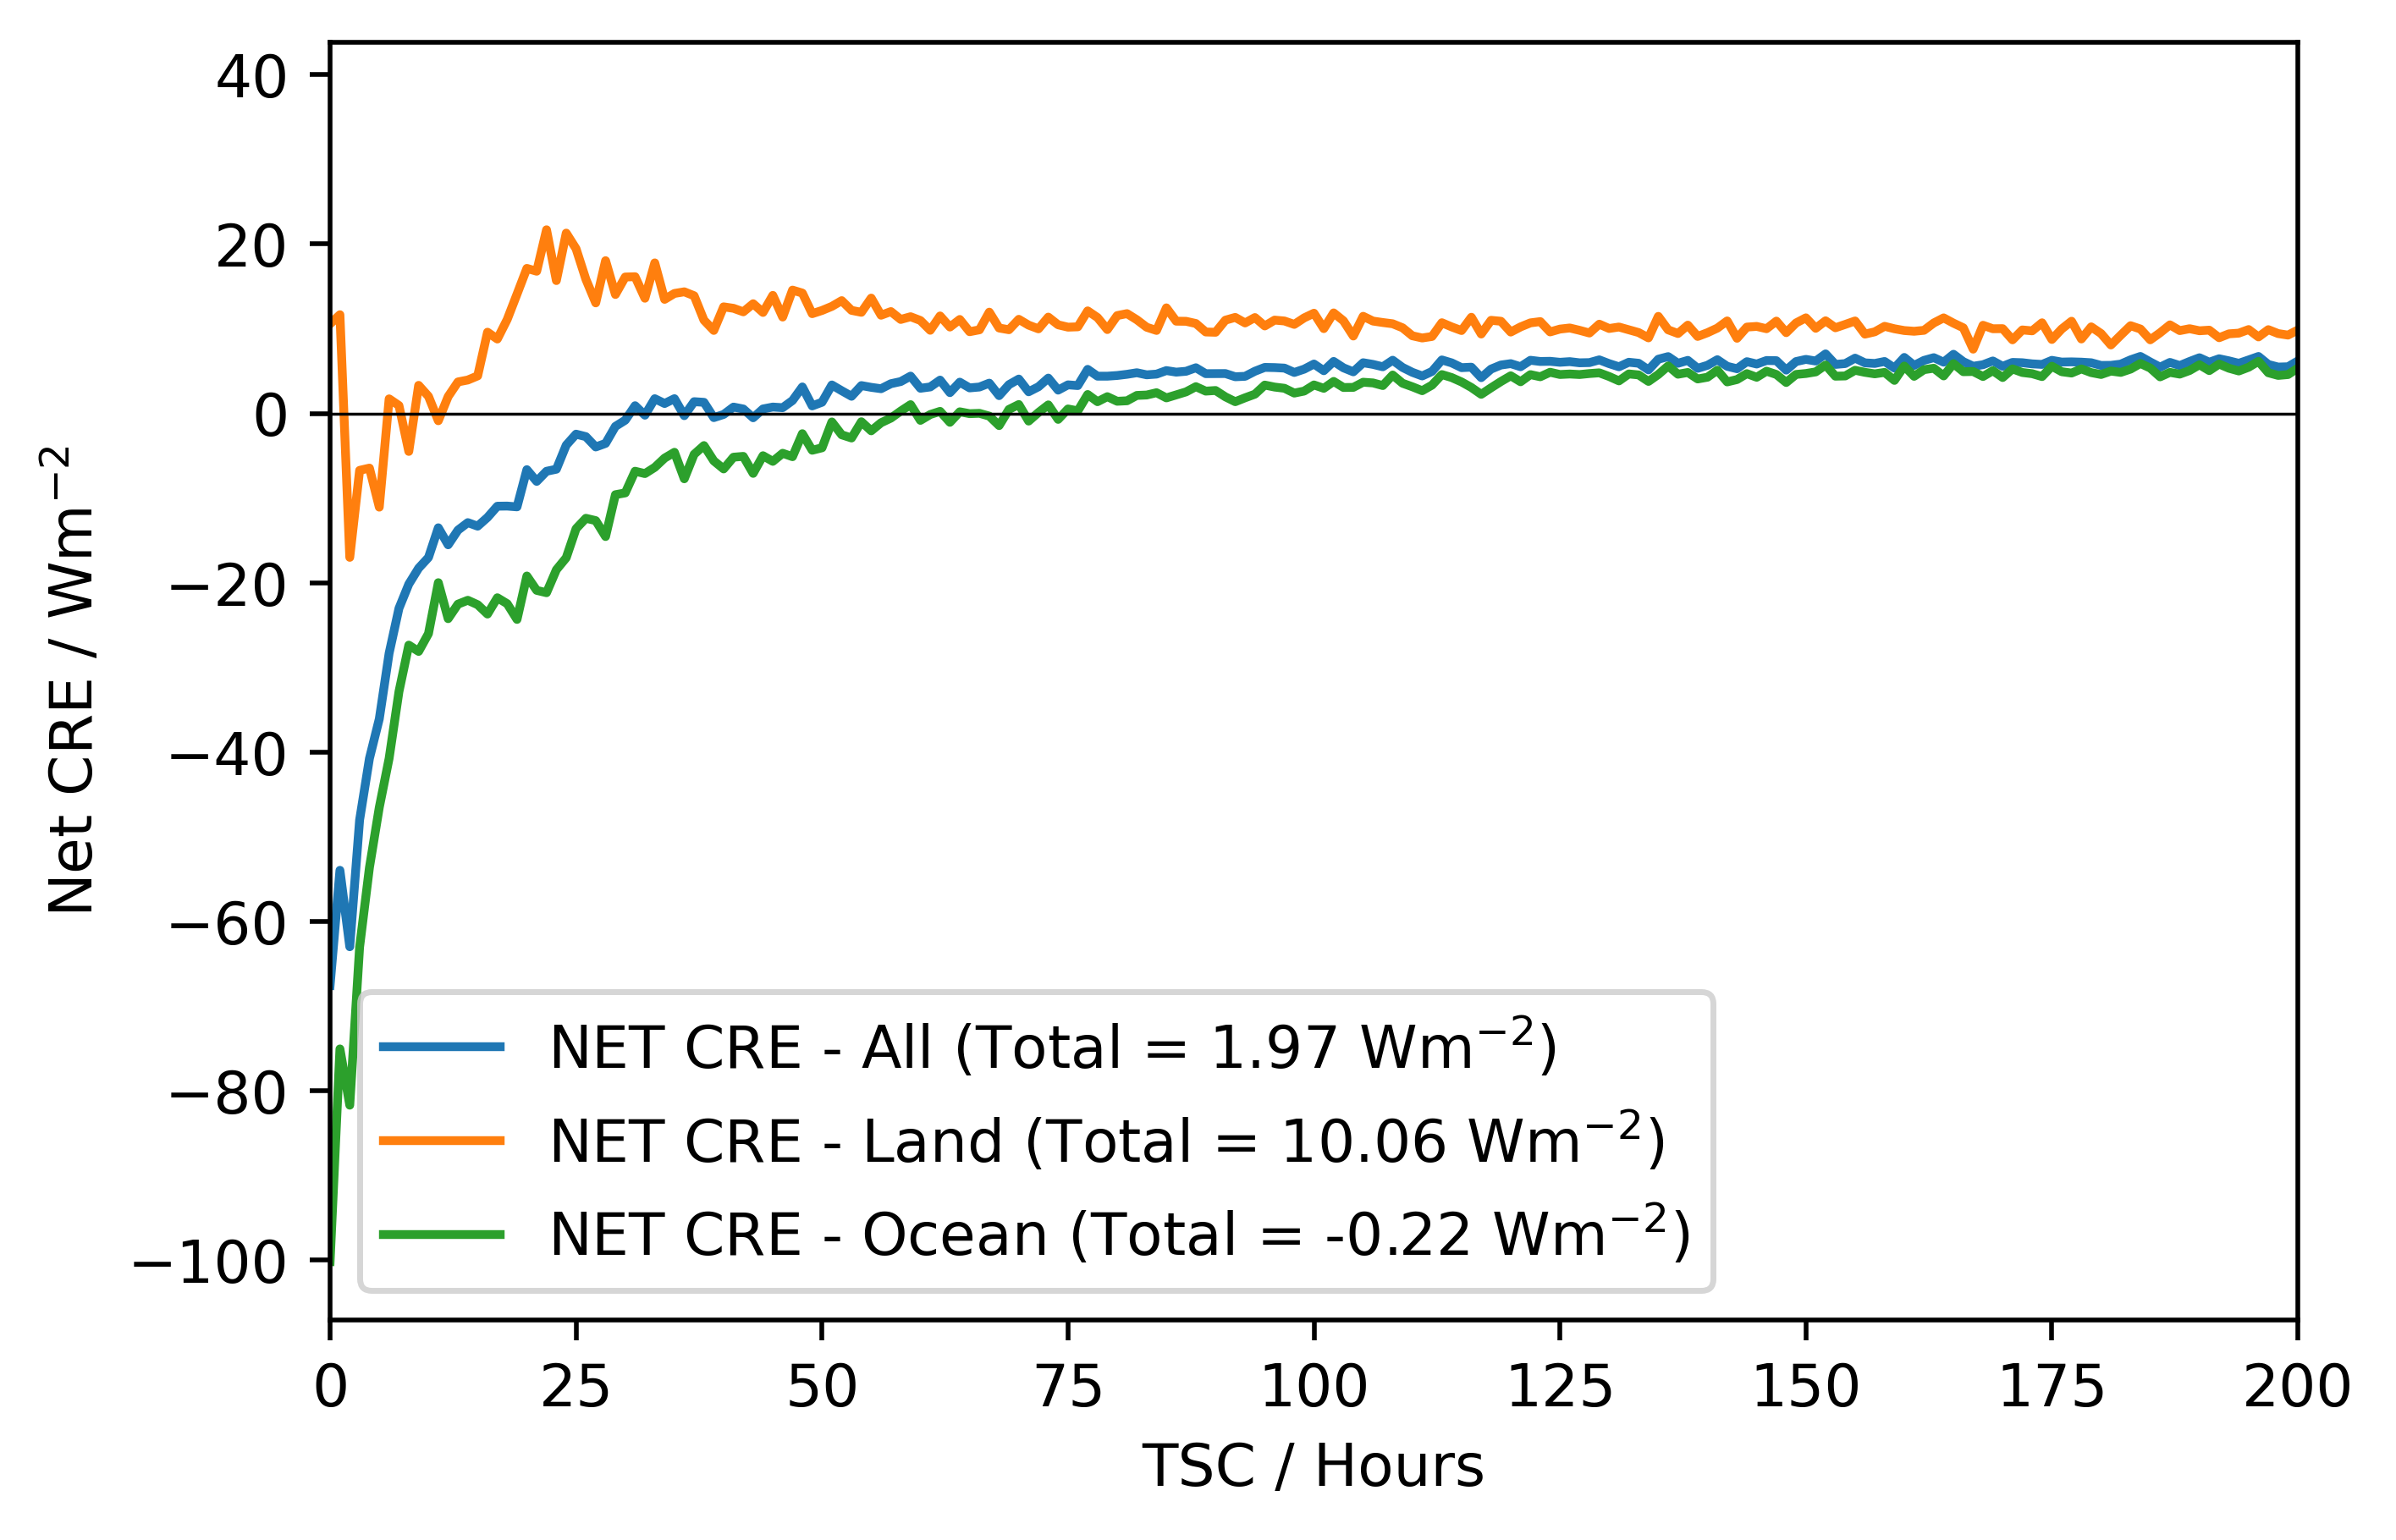

In [27]:
#plt.plot(SW_AVERAGE_all,label='All')
#plt.plot(LW_AVERAGE_all,label='All')
#plt.plot((SW_AVERAGE_det * (counts_det / counts)) + (SW_AVERAGE_ins * counts_ins/counts))

plt.figure(dpi=500)
plt.plot(weightedlw+weightedsw,label='NET CRE - All (Total = '+str(round(totalforcing,2))+' Wm$^{-2}$)')
plt.plot(weightedlw_l+weightedsw_l,label='NET CRE - Land (Total = '+str(round(totalforcing_land,2))+' Wm$^{-2}$)')
plt.plot(weightedlw_o+weightedsw_o,label='NET CRE - Ocean (Total = '+str(round(totalforcing_ocean,2))+' Wm$^{-2}$)')

plt.xlabel('TSC / Hours')
plt.ylabel('Net CRE / Wm$^{-2}$')

plt.axhline(0,color='k',linewidth=0.5)
plt.legend()
plt.xlim(0,200)
plt.savefig('CRE_Net_LandOcean.png',dpi=700)
#plt.ylim(-300,200)
#plt.ylim(-10,10)

### lifetime_Extension

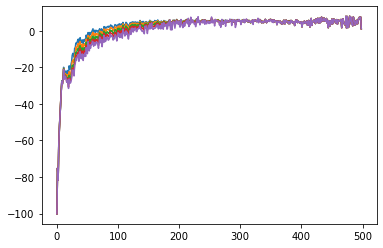

In [47]:
totalforcing = []
totalforcing_land = []
totalforcing_ocean = []

totalextcounts = np.zeros((100,499))
totalextcounts_det = np.zeros((100,499))
totalextcounts_ins = np.zeros((100,499))

totalextcounts_o = np.zeros((100,499))
totalextcounts_l = np.zeros((100,499))
totalextcounts_o_d = np.zeros((100,499))
totalextcounts_l_d = np.zeros((100,499))
totalextcounts_o_i =  np.zeros((100,499))
totalextcounts_l_i = np.zeros((100,499))

for i in range(100,200):
    xloc = (np.arange(len(counts_det)))
    newsize = int((len(counts_det)*(i/100)))
    new_xloc = np.linspace(0, len(counts_det), newsize)
    extcounts_det = np.interp(new_xloc, xloc, counts_det)
    extcounts_ins = np.interp(new_xloc, xloc, counts_ins)
    extcounts = np.interp(new_xloc, xloc, counts)

    extcounts_det_l = np.interp(new_xloc, xloc, counts_d_l)
    extcounts_ins_l = np.interp(new_xloc, xloc, counts_i_l)
    extcounts_l = np.interp(new_xloc, xloc, counts_l)

    extcounts_det_o = np.interp(new_xloc, xloc, counts_d_o)
    extcounts_ins_o = np.interp(new_xloc, xloc, counts_i_o)
    extcounts_o = np.interp(new_xloc, xloc, counts_o)

    weightedlw = (LW_AVERAGE_det * (extcounts_det[0:499] / extcounts[0:499])) + (LW_AVERAGE_ins * (extcounts_ins[0:499]/extcounts[0:499]))
    weightedsw = (SW_AVERAGE_det * (extcounts_det[0:499] / extcounts[0:499])) + (SW_AVERAGE_ins * (extcounts_ins[0:499]/extcounts[0:499]))

    weightedlw = np.where(np.isnan(weightedlw),LW_AVERAGE_all,weightedlw)
    weightedsw = np.where(np.isnan(weightedsw),SW_AVERAGE_all,weightedsw)

    weightedlw_l = (LW_AVERAGE_det_l * (extcounts_det_l[0:499] / extcounts_l[0:499])) + (LW_AVERAGE_ins_l * (extcounts_ins_l[0:499]/extcounts_l[0:499]))
    weightedsw_l = (SW_AVERAGE_det_l * (extcounts_det_l[0:499] / extcounts_l[0:499])) + (SW_AVERAGE_ins_l * (extcounts_ins_l[0:499]/extcounts_l[0:499]))

    weightedlw_l = np.where(np.isnan(weightedlw_l),LW_AVERAGE_land,weightedlw_l)
    weightedsw_l = np.where(np.isnan(weightedsw_l),SW_AVERAGE_land,weightedsw_l)

    weightedlw_o = (LW_AVERAGE_det_o * (extcounts_det_o[0:499] / extcounts_o[0:499])) + (LW_AVERAGE_ins_o * (extcounts_ins_o[0:499]/extcounts_o[0:499]))
    weightedsw_o = (SW_AVERAGE_det_o * (extcounts_det_o[0:499] / extcounts_o[0:499])) + (SW_AVERAGE_ins_o * (extcounts_ins_o[0:499]/extcounts_o[0:499]))

    weightedlw_o = np.where(np.isnan(weightedlw_o),LW_AVERAGE_ocean,weightedlw_o)
    weightedsw_o = np.where(np.isnan(weightedsw_o),SW_AVERAGE_ocean,weightedsw_o)
    
    
    lwsum = np.nansum(weightedlw[:]*(extcounts[0:499]))/np.nansum(extcounts[0:499])
    swsum = np.nansum(weightedsw[:]*(extcounts[0:499]))/np.nansum(extcounts[0:499])

    lwsum_land = np.nansum(weightedlw_l[:]*extcounts_l[0:499])/np.nansum(extcounts_l[0:499])
    swsum_land = np.nansum(weightedsw_l[:]*extcounts_l[0:499])/np.nansum(extcounts_l[0:499])

    lwsum_ocean = np.nansum(weightedlw_o[:]*extcounts_o[0:499])/np.nansum(extcounts_o[0:499])
    swsum_ocean = np.nansum(weightedsw_o[:]*extcounts_o[0:499])/np.nansum(extcounts_o[0:499])

    if i%20==0:
        plt.plot(weightedlw_o+weightedsw_o,label='All')

    totalforcing.append(lwsum+swsum)
    totalforcing_land.append(lwsum_land+swsum_land)
    totalforcing_ocean.append(lwsum_ocean+swsum_ocean)

    totalextcounts[i - 100] = extcounts[0:499]
    totalextcounts_det[i - 100] = extcounts_det[0:499]
    totalextcounts_ins[i - 100] = extcounts_ins[0:499]

    totalextcounts_o[i - 100] = extcounts_o[0:499]
    totalextcounts_l[i - 100] = extcounts_l[0:499]
    totalextcounts_o_d[i -100] = extcounts_det_o[0:499]
    totalextcounts_l_d[i-100] = extcounts_det_l[0:499]
    totalextcounts_o_i[i-100] = extcounts_ins_o[0:499]
    totalextcounts_l_i[i-100] = extcounts_ins_l[0:499]

(0.0, 120.0)

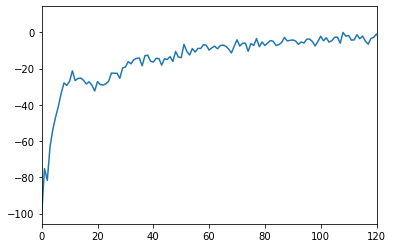

In [46]:
plt.plot(weightedlw_o+weightedsw_o,label='All')
plt.xlim(0,120)

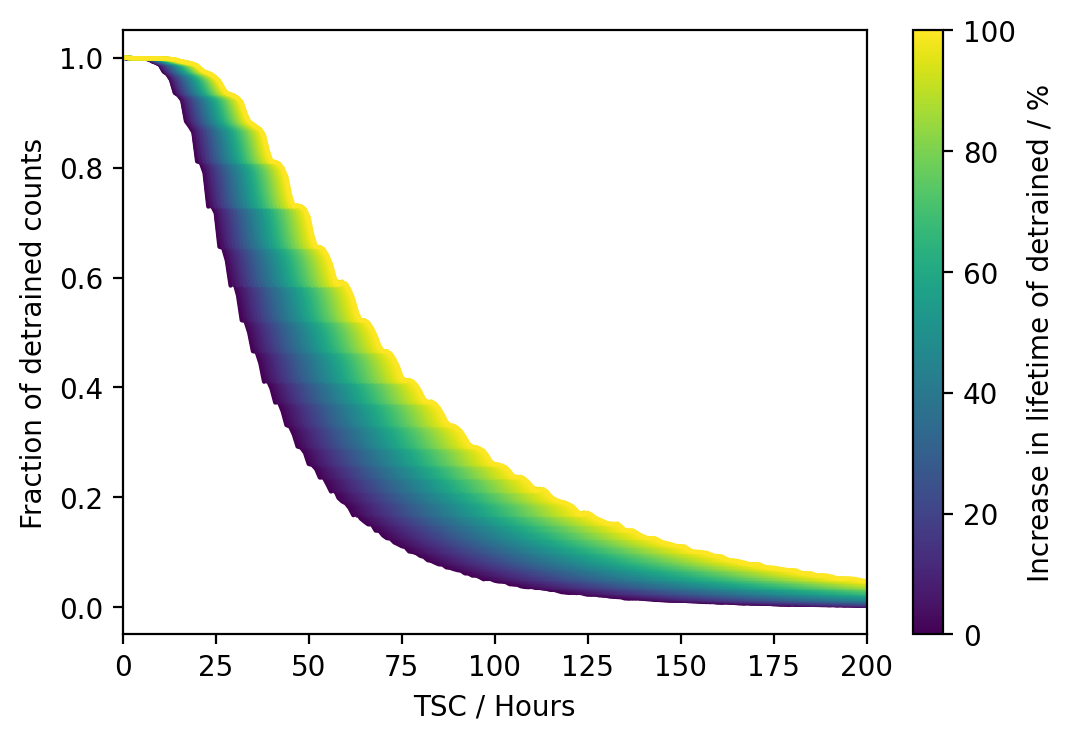

In [84]:
plt.figure(dpi=200)
colormap = plt.cm.gist_ncar
camp = plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.viridis(np.linspace(0,1,100))))

for i in range(0,100):
    plt.plot(totalextcounts_det[i]/totalextcounts[i])

norm = mpl.colors.Normalize(vmin=0,vmax=100)
sm = plt.cm.ScalarMappable(cmap=camp, norm=norm)

sm.set_array([])
plt.colorbar(sm,label='Increase in lifetime of detrained / %')
plt.xlabel('TSC / Hours')
plt.ylabel('Fraction of detrained counts')
plt.xlim(0,200)
plt.savefig('Lifetime_detrain.png',dpi=700)

<AxesSubplot:>

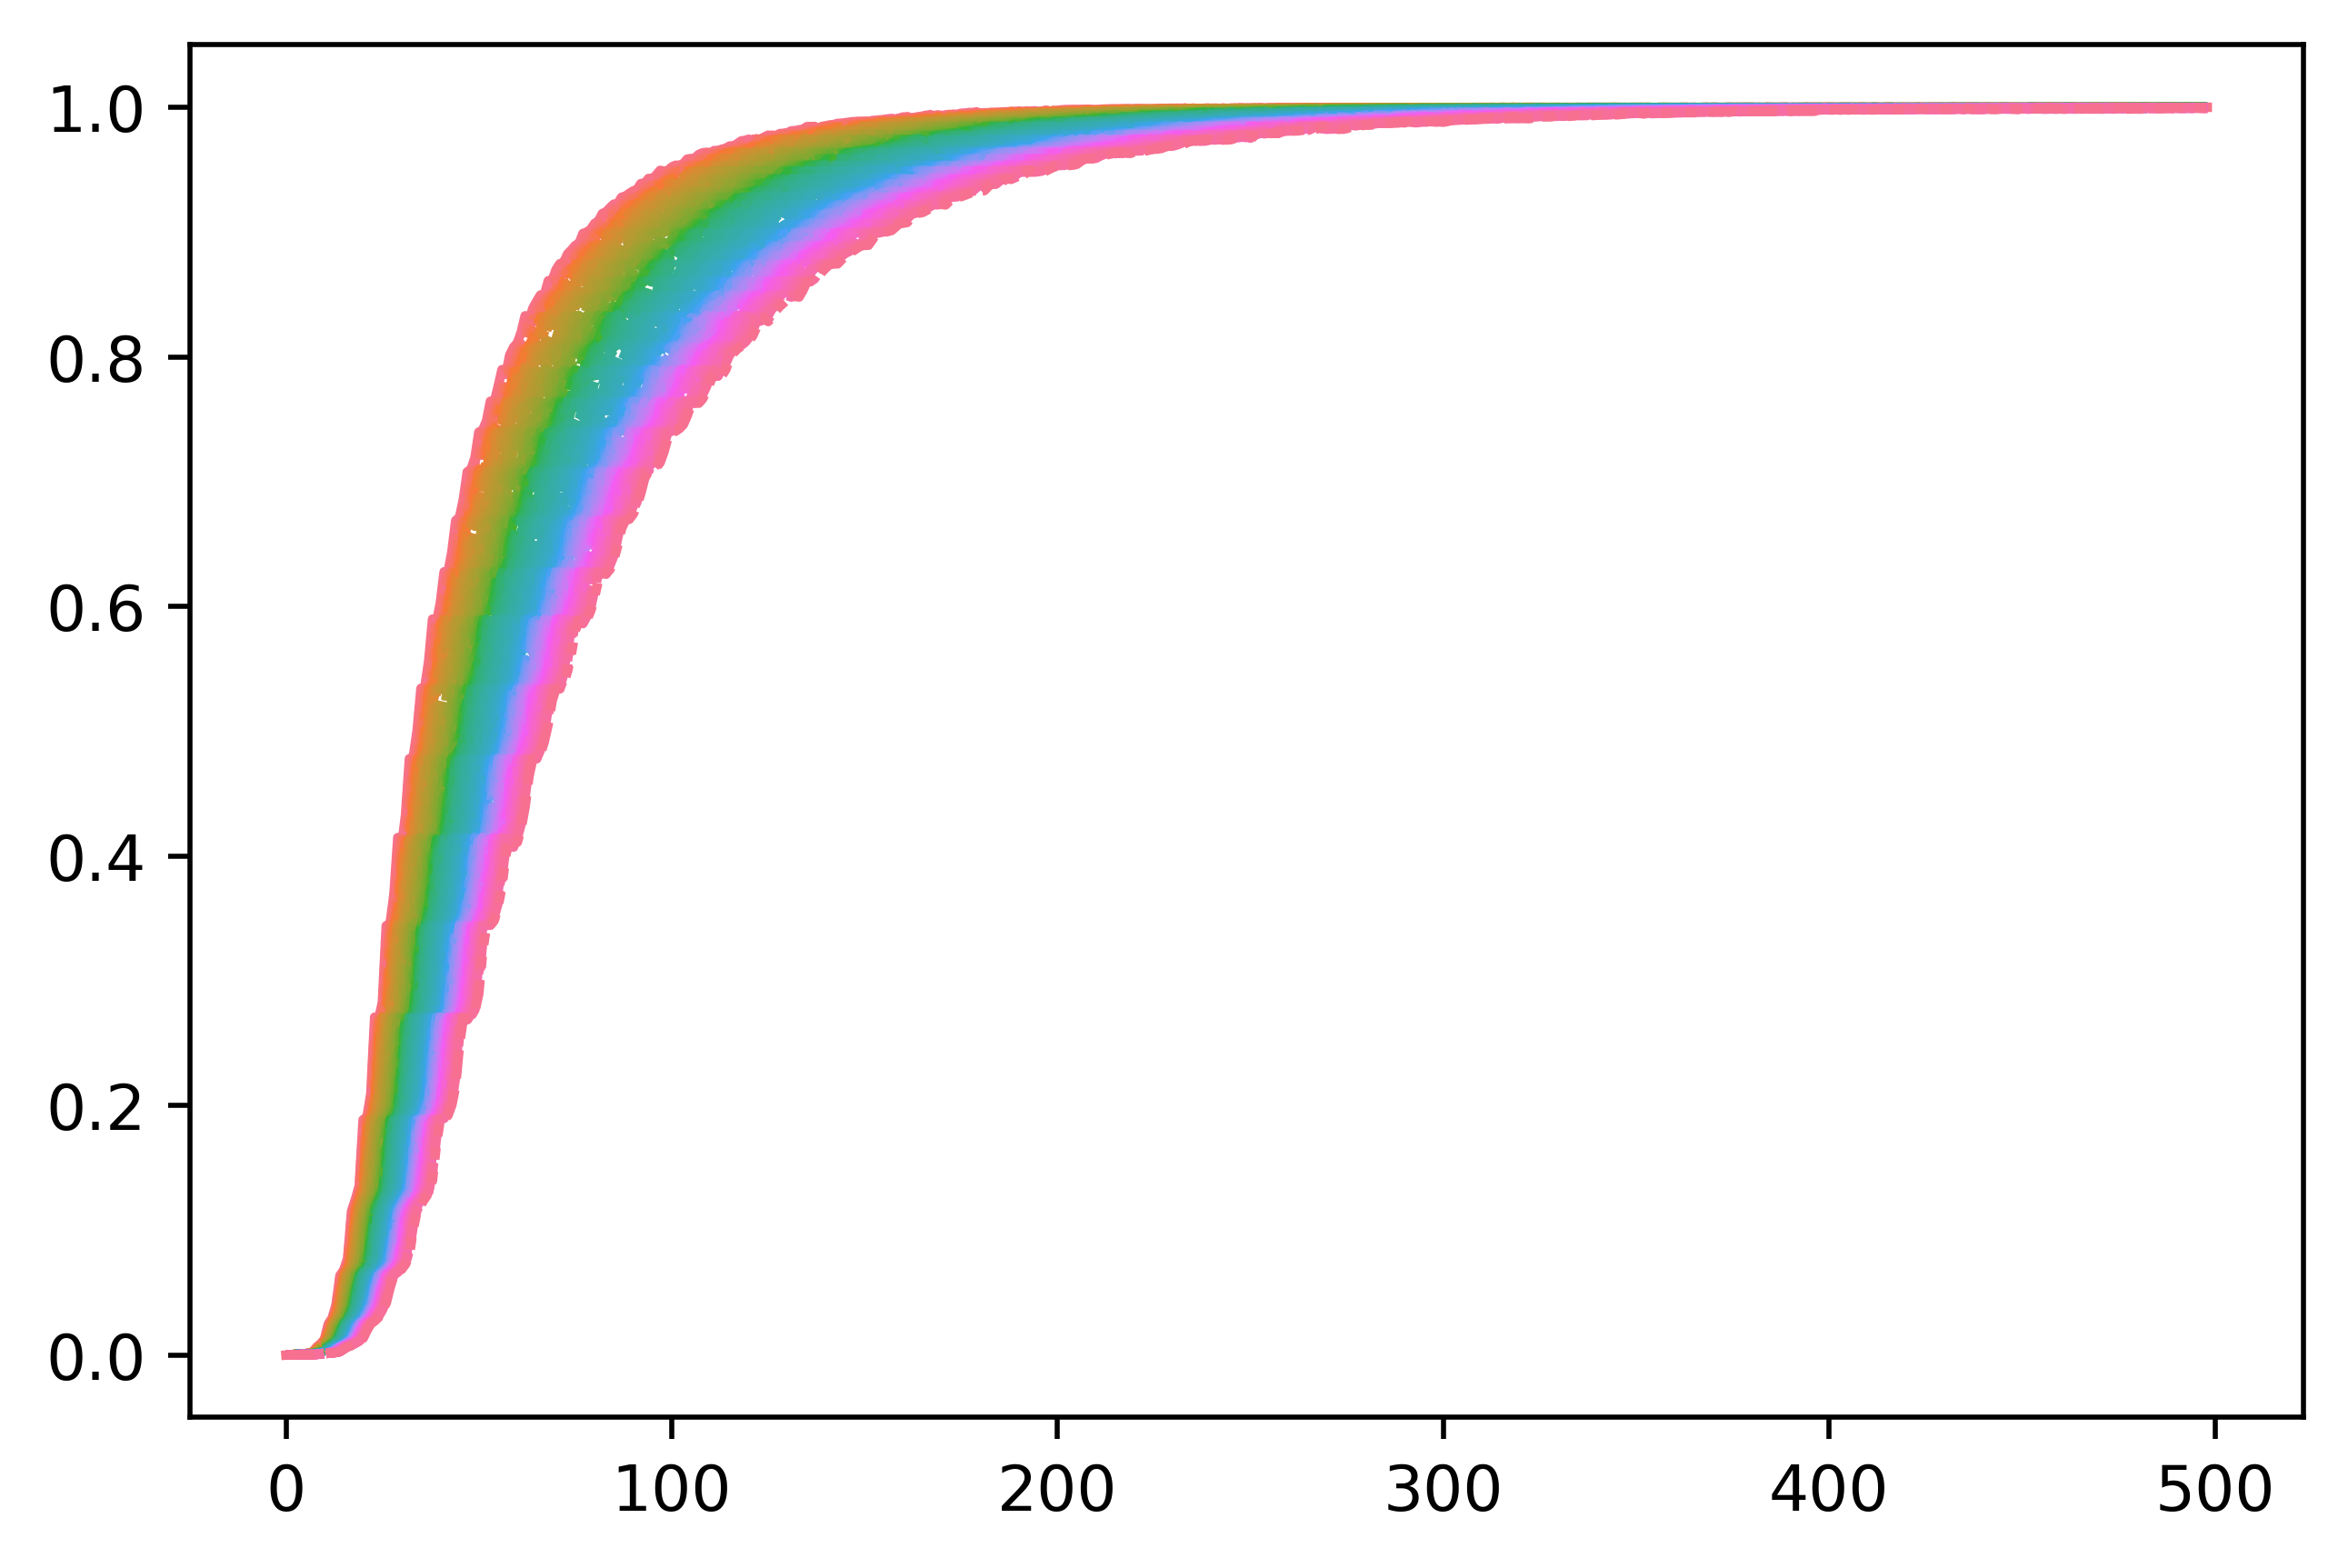

In [51]:
import seaborn as sns
plt.figure(dpi=500)
sns.lineplot(data=totalextcounts_ins.T/totalextcounts.T,legend=False)

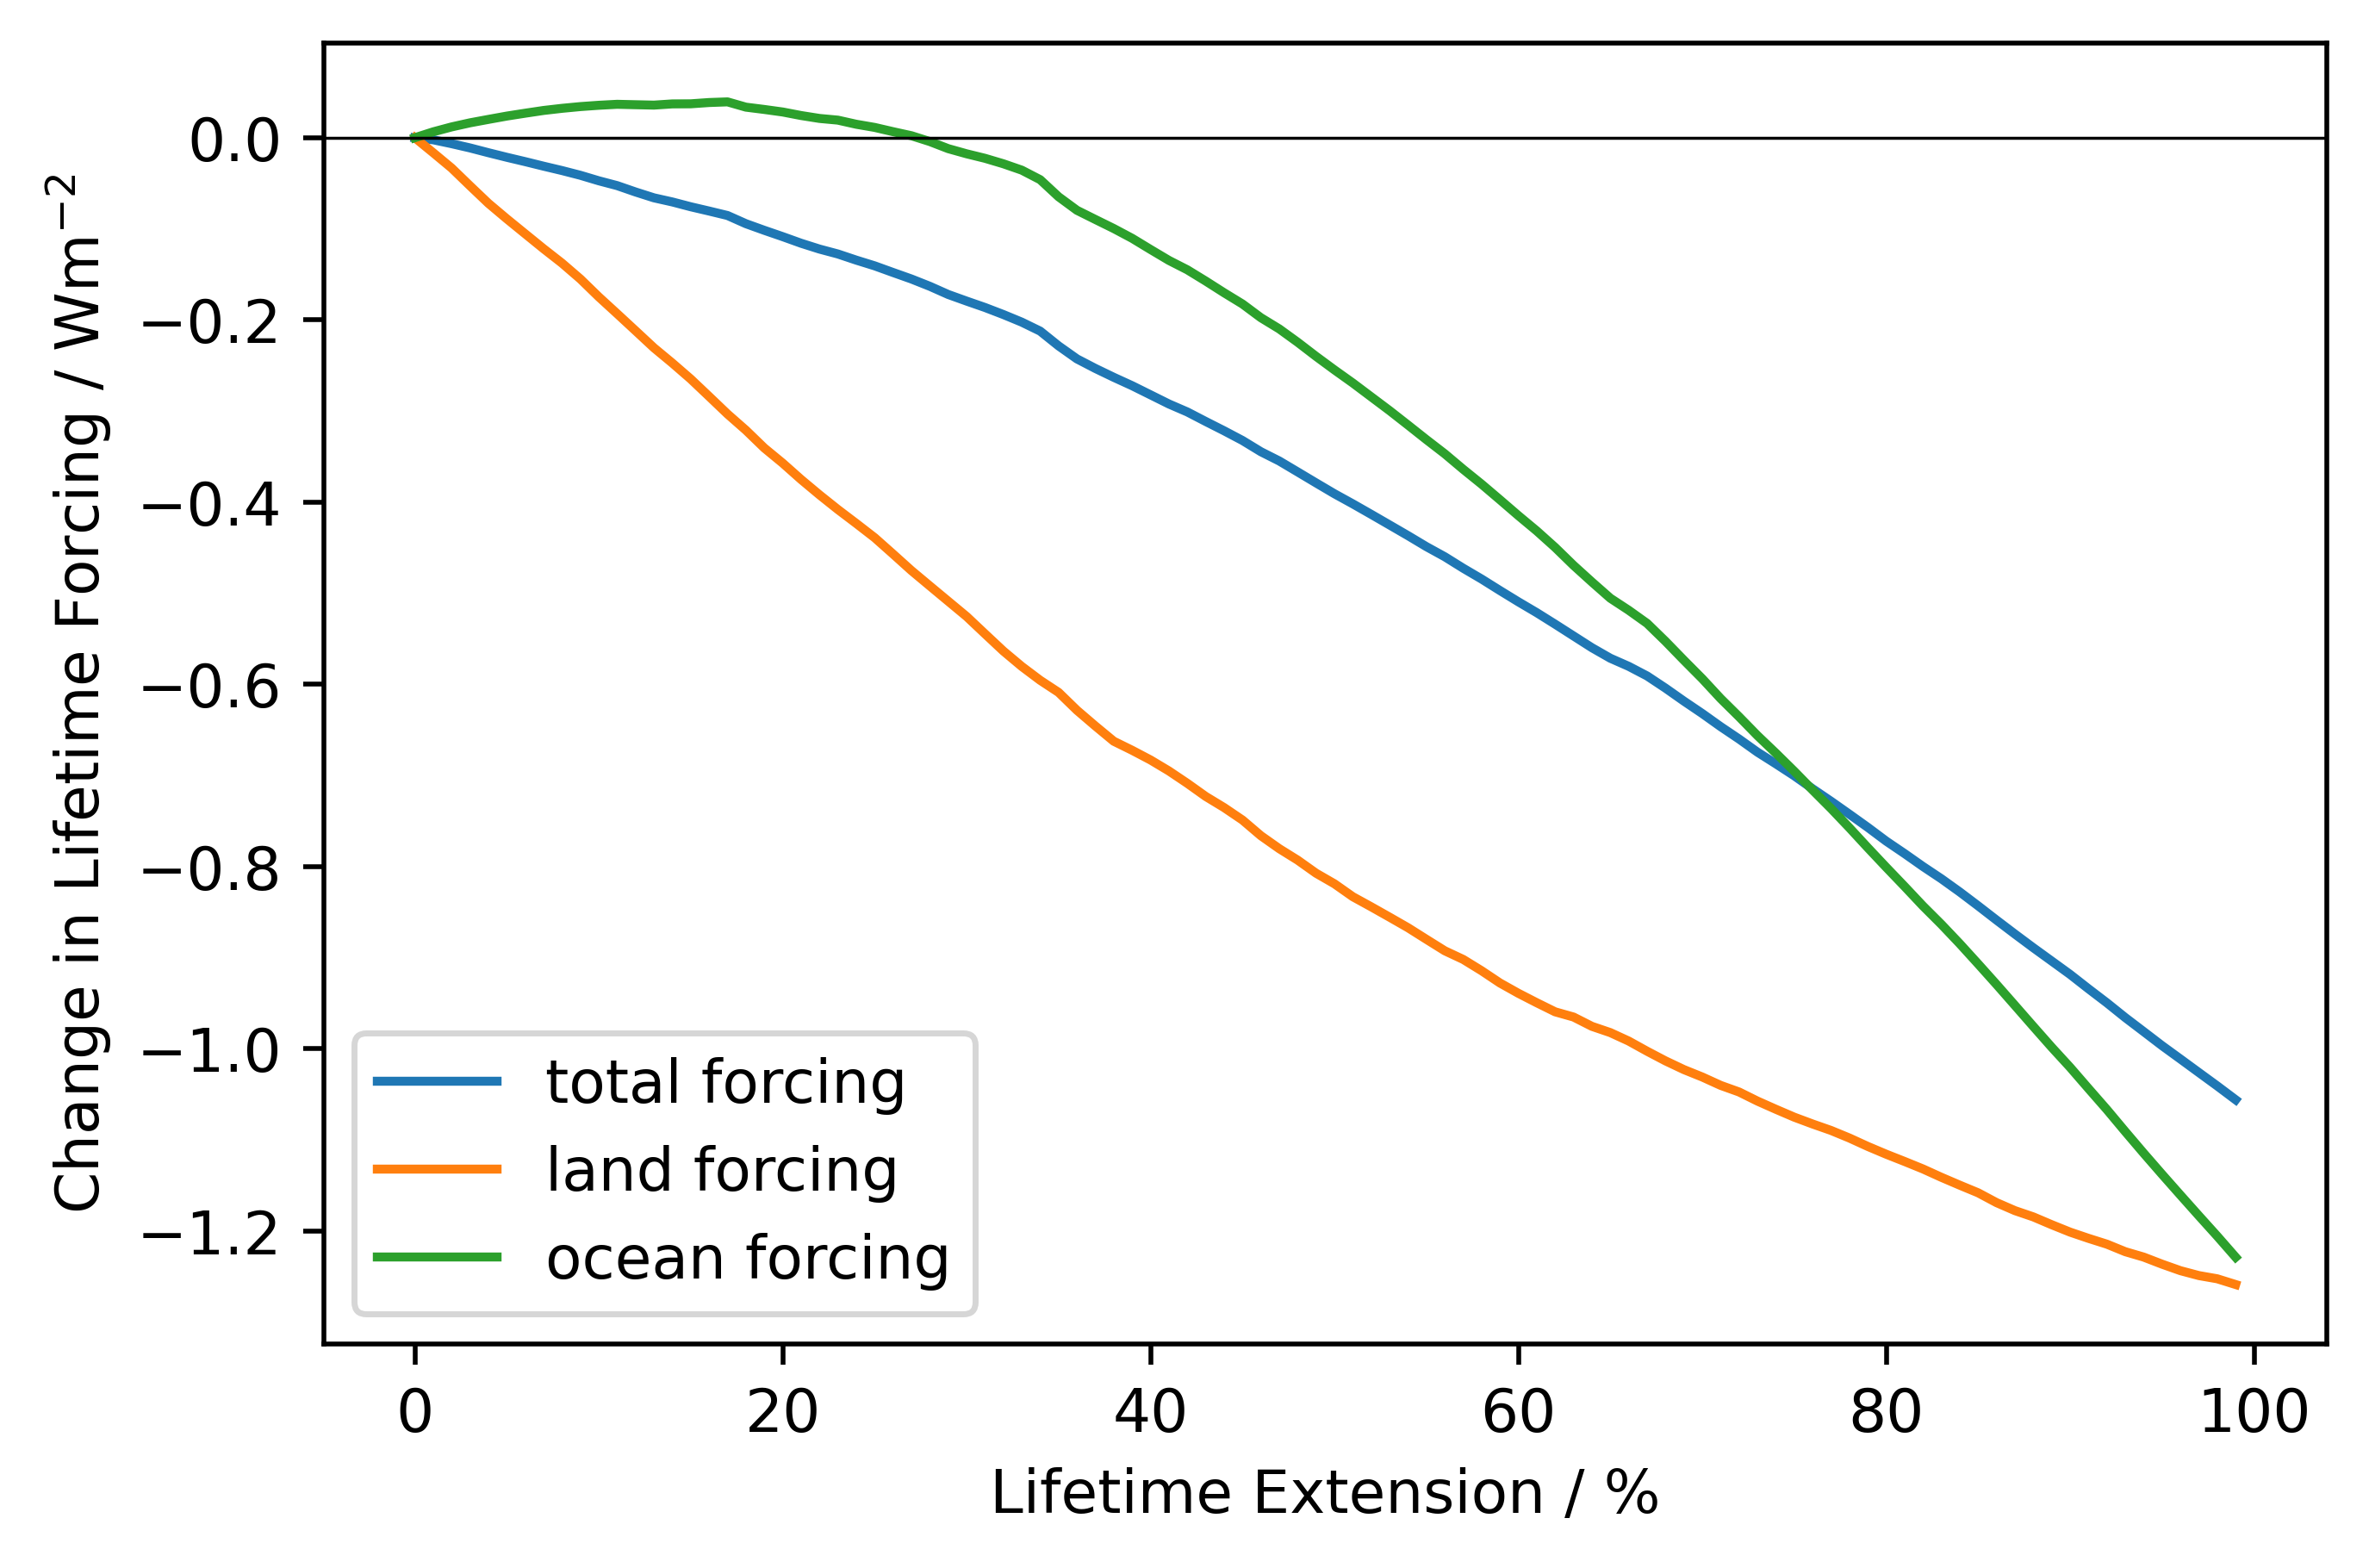

In [45]:
plt.figure(dpi=500)
plt.plot(totalforcing - np.abs(totalforcing[0]), label='total forcing')
plt.plot(totalforcing_land - np.abs(totalforcing_land[0]),label='land forcing')
plt.plot(totalforcing_ocean - (totalforcing_ocean[0]),label='ocean forcing')
plt.axhline(0,color='k',linewidth=0.5)
plt.xlabel('Lifetime Extension / %')
plt.ylabel('Change in Lifetime Forcing / Wm$^{-2}$')
plt.legend()
plt.savefig('lifetimechange.png',dpi=700)

(0.0, 500.0)

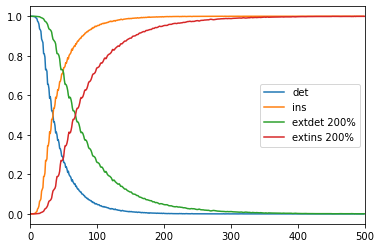

In [88]:
plt.plot(counts_det/counts,label='det')
plt.plot(counts_ins/counts,label='ins')

plt.plot(extcounts_det/extcounts,label='extdet 200%')
plt.plot(extcounts_ins/extcounts,label='extins 200%')
plt.legend()
plt.xlim(0,500)

In [18]:
totalextcounts.shape

AttributeError: 'list' object has no attribute 'shape'